In [1]:
%matplotlib notebook
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt


import os
import threedhst.eazyPy as eazy
import subprocess
import shutil

from astropy.io import ascii
from astropy.wcs import WCS

from photutils import detect_threshold
from photutils import detect_sources
from photutils import source_properties, properties_table 
from photutils import deblend_sources

from photutils.utils import random_cmap
from photutils.utils import calc_total_error


from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from mpl_toolkits.axes_grid1 import make_axes_locatable


No TEAL-based tasks available for this package!
The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

=  THREEDHST.__init__.defaultOptions  =

Initializing THREEDHST parameters

=========== 2017/2/2 21:49 ============


 but the reduction scripts should be OK.



# Functions

In [2]:
# Вырезаем нужную область
def cut_fits(fits,newfit,pix,x,y):

    sor = pf.open(fits)
    hdu = sor[0]
    Rad = pix

    xx = x
    yy = y

    sts = pf.PrimaryHDU(data=hdu.data[int(yy - Rad): int(yy + Rad), int(xx - Rad): int(xx + Rad)], header=hdu.header)
    sts.writeto(newfit, clobber=True)

    print('ax, ay', int(xx - Rad), yy - Rad)
    print('Rad', Rad)
    
    
# Нахождение обьектов в нужной области    
def finding(ax,ay,rad):
    
    X = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 1]
    Y = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 2]
    ID = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 0]
    
    X0 = []
    Y0 = []
    ID0 = []
    
    for i in range(len(X)):

        if (0 < X[i] - ax < 2*rad) and (0 < Y[i] - ay < 2*rad):
            X0.append(X[i] - ax)
            Y0.append(Y[i] - ay)
            ID0.append(ID[i])

    ZZZ = np.vstack((ID0, X0, Y0))
    np.savetxt('Table_gold.dat', np.transpose(ZZZ), delimiter="  ", fmt="%s")

    VV = np.genfromtxt('Table_gold.dat')[:, 1]
    print('Galaxes',VV.shape[0])     

    
#beg = '/home/tuberozova/eazy-photoz/inputs/goodss_3dhst.v4.1/'   
#end = '/home/tuberozova/threedhst/OUTPUT/'

# Скопировали все файлы туда где будем работать
def copy_files(beg, end):
    dest = end                      # куда копируем
    src = beg                       # откуда копируем
    src_f = os.listdir(src)

    # copy all files
    for f in src_f:
        full_file_name = os.path.join(src, f)
        if (os.path.isfile(full_file_name)):
            shutil.copy(full_file_name, dest)
 
 

# Скопировать один определенный файл
def copy_one_file(pl_1_file, pl_2_file):
    
    shutil.copyfile(pl_1_file, pl_2_file)  
    
    
    
# Запускаем eazy

# Настраиваем конфигурационный файл
# a -    APPLY_PRIOR  (1 or 0)
def config_f(c_name, catalog, z_m, a):
    os.chdir('/home/tuberozova/eazy-photoz/inputs/') 
    with open('good.param') as f:
        content = f.readlines()

    l_1 = len(catalog) 
    l_2 = len(str(z_m))
    
    content[23]  = content[23][:21]  + catalog           + content[23][21+l_1:]
    content[48] = content[48][:21]   + str(z_m)          + content[48][21+l_2:]
    content[40] = content[40][:21]   + str(a)            + content[40][22:]
    

    y = open(c_name + '.param', 'w')
    for i in content:
        y.write("%s" % i)
    y.close()
    os.chdir('/home/tuberozova/threedhst') 
    
    
# config = 'good.param'
def eazy(config):
    os.chdir('/home/tuberozova/eazy-photoz/inputs/') 
    subprocess.call(['ls'])

    std = open('log.txt', 'wb')
    subprocess.call(['../src/eazy', '-p', config,'-t','goodss_3dhst.v4.1.translate'], stdout= std)

    os.chdir('/home/tuberozova/threedhst') 
    print('hah') 

    
# Работа с архивом данных, остаются только те, номера которых указаны в filtr
def find(cat, name, filtr):
    
    with open(cat, 'r') as f:
        with open(name, 'w') as y:
            lines = f.readlines()
            
            for i, line in enumerate(lines):
                if i<=1:
                    y.write(line) 
                for j in range(len(filtr)):
                    if i == filtr[j]+1:
                        y.write(line)
    print('done')
                        
#cat = 'goodss_3dhst.v4.1.cat'
#name = 'c.txt'
#n = np.array([3,4])
#filtr = n
#find('goodss_3dhst.v4.1.cat','c.txt', n)




# Работа sextractor:

    
# name_f - имя фитс файла для обработки
# config_n - имя конфигурационного файла
def Sextr(name_f,config_n):
    
    os.chdir('/home/tuberozova/sextractor-2.19.5/tests/') 
    
    
    treshold = 2.8                                 #   DETECT_THRESH
    npixel   = 3                                   #   DETECT_MINAREA -  min  of pixels above threshold
    radius   = '2.0, 3.7'                          #   PHOT_AUTOPARAMS  -  # MAG_AUTO parameters: <Kron_fact>,<min_radius>
    catalog_type  = 'ASCII_SKYCAT'
    D_NTH = 62                                     #   DEBLEND NTHRESH is the number of levels allowed between the threshold and the
                                                   #   maximum count in the object.

                                                    
    Minont = 0.0005                                #   DEBLEND MINCONT, sets the minimum flux ratio between the small galaxy and the bright star
                                                   #   for which the galaxy will successfully be detected.

    
    with open('c125.txt') as f:
        content = f.readlines()

    content[6]  = content[6][:17]  + 'parmtr'        + content[6][23:]
    content[34] = content[34][:17] + radius          + content[34][25:]
    content[65] = content[65][:17] + 'check'         + content[65][22:]
    content[14] = content[14][:17] + str(npixel)     + content[14][18:]
    content[16] = content[16][:17] + str(treshold)   + content[16][20:]

    y = open(config_n + '.txt', 'w')
    for i in content:
        y.write("%s" % i)
    y.close()

    subprocess.call(['../src/sex', name_f + '.fits',  '-c', config_n + '.txt'])


    plt.figure(1,figsize=(10,10))
   
    data = pf.open('check.fits')
    img = data[0].data
    
    plt.imshow(img, interpolation='nearest', cmap='gray', vmin=1.e-3, vmax=5)
    plt.title('Objects')
    #plt.show(1)
    plt.savefig('Fig.pdf',dpi=300)
    
    os.chdir('/home/tuberozova/threedhst') 
    print('haha') 
    
print('Load all')

Load all


# Data Processing

In [57]:
# Work with sextractor:
# 'parmtr.cat' - таблица с обьектами
Sextr('gold', 'gold_c')
way_1 = '/home/tuberozova/sextractor-2.19.5/tests/'

print('Number_objects', len(np.genfromtxt(way_1 + 'parmtr.cat', skip_header=15)[:,0]))


haha
('Number_objects', 309)


In [85]:
# Copy results from sextractor:
copy_one_file('/home/tuberozova/sextractor-2.19.5/tests/parmtr.cat','/home/tuberozova/threedhst/parmtr.cat')
copy_one_file('/home/tuberozova/sextractor-2.19.5/tests/check.fits','/home/tuberozova/threedhst/check.fits')

In [115]:
# Working with EAZY: трудности с тем, что файл из секстрактора
config_f('c_n', 'parmtr.cat',11.000,1)
eazy('c_n')



In [22]:
# Working with EAZY:
config_f('c_n', 'goodss_3dhst.v4.1.cat',12.000,1)
eazy('c_n.param')


hah


In [46]:
copy_one_file('/home/tuberozova/eazy-photoz/inputs/goodss_3dhst.v4.1/goodss_3dhst.v4.1.zout','/home/tuberozova/threedhst/goodss_3dhst.v4.1.zout')
copy_files('/home/tuberozova/eazy-photoz/inputs/goodss_3dhst.v4.1/','/home/tuberozova/threedhst/OUTPUT/' )

# Loading Data

In [3]:
# 1 main picture
main_pic = 'goodss_3dhst.v4.0.F125W_F140W_F160W_det.fits'
f = pf.open(main_pic)
pic = f[0].data

w = WCS(main_pic)

# 2 main catalog
main_cat = np.genfromtxt('goodss_3dhst.v4.1.cat', skip_header=2)


# 3 catalog from website
cat = np.genfromtxt('asu.tsv', skip_header=56, delimiter='\t', dtype=None)
cat_xy = np.array(w.wcs_world2pix(cat['f0'],cat['f1'], 0)).T
Z = cat['f8']

# 4 Загружаем данные с красными смещениями
way = '/home/tuberozova/threedhst/OUTPUT/'
cat_z = np.genfromtxt(way + 'goodss_3dhst.v4.1.zout', skip_header=1)
print('Ready')

Ready


# Work with Asu.tsv

In [4]:
fil= (Z > 7)
g=0

for i in range(len(fil)):
    if fil[i] == True:
        g +=1
print(g)

A = cat_xy[:,0][fil]
B = cat_xy[:,1][fil]
z = Z[fil]

ao = []
bo = []
zo = []
for i in range (len(A)):
    if (A[i] > 0) & (B[i] > 0):
        ao.append(A[i])
        bo.append(B[i])
        zo.append(z[i])
        
print(len(ao),len(bo),len(zo))
#Yi = np.vstack((A, B, z))


297
(151, 151, 151)


In [5]:
x_p = []
y_p = []
z_p = []
l=0

for i in range(len(ao)+1):
    for j in range(i+1, len(ao)):
        if (0<abs(ao[i] - ao[j]) < 30) & (0< abs(bo[i] - bo[j]) <30)&(0< abs(zo[i] - zo[j]) < 3):
            x_p.append(ao[i])
            x_p.append(ao[j])
            y_p.append(bo[i])
            y_p.append(bo[j])
            z_p.append(zo[i])
            z_p.append(zo[j])
            l+=1
print(l)
print(x_p) 
print(y_p)
print(z_p)
Ye = np.vstack((x_p, y_p, z_p))
np.savetxt('asu_p.dat', np.transpose(Ye), delimiter="  ", fmt="%s")

9
[2711.6059582824892, 2720.6080458087408, 8705.211831984223, 8691.945859877058, 8705.211831984223, 8705.2122721888682, 7286.8301586180951, 7286.8431874130665, 8691.945859877058, 8705.2122721888682, 6919.6277892338912, 6928.6460495352403, 8072.2897101810722, 8085.5564080666809, 7275.7012280440813, 7286.8431874130665, 7286.8431874130665, 7275.7012280440813]
[7560.2142508609331, 7574.0247962366338, 10793.045034224237, 10782.841777357366, 10793.045034224237, 10791.24503443918, 12472.544582702049, 12444.344572270777, 10782.841777357366, 10791.24503443918, 12155.564565766508, 12167.569237602598, 11614.259628547035, 11624.464146024511, 12430.539412257194, 12444.344572270777, 12444.344572270777, 12430.539412257194]
[7.3300000000000001, 7.4900000000000002, 7.2400000000000002, 7.6600000000000001, 7.2400000000000002, 7.4100000000000001, 7.75, 7.8399999999999999, 7.6600000000000001, 7.4100000000000001, 7.4900000000000002, 7.5800000000000001, 7.4900000000000002, 7.3300000000000001, 7.5800000000000

In [7]:
print(x_p[0],y_p[0],z_p[0])
print(x_p[1],y_p[1],z_p[1])
print()
print(x_p[8],y_p[8],z_p[2])
print(x_p[2],y_p[2],z_p[3])
print(x_p[3],y_p[3],z_p[4])
print(x_p[4],y_p[4],z_p[5])
print(x_p[5],y_p[5],z_p[6])
print()
print(x_p[6],y_p[6],z_p[7])
print(x_p[7],y_p[7],z_p[8])


(2711.6059582824892, 7560.2142508609331, 7.3300000000000001)
(2720.6080458087408, 7574.0247962366338, 7.4900000000000002)
()
(8691.945859877058, 10782.841777357366, 7.2400000000000002)
(8705.211831984223, 10793.045034224237, 7.6600000000000001)
(8691.945859877058, 10782.841777357366, 7.2400000000000002)
(8705.211831984223, 10793.045034224237, 7.4100000000000001)
(8705.2122721888682, 10791.24503443918, 7.75)
()
(7286.8301586180951, 12472.544582702049, 7.8399999999999999)
(7286.8431874130665, 12444.344572270777, 7.6600000000000001)


('ax, ay', 2665, 7517)
('Rad', 50)


<IPython.core.display.Javascript object>


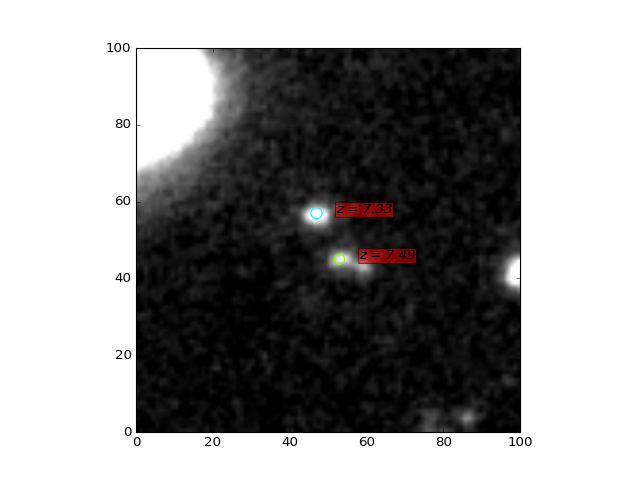

In [6]:
cut_fits(main_pic,'pair.fits',50, 2715, 7567)

sot = pf.open('pair.fits')
image_data = sot[0].data

plt.close(20)
plt.figure(20)
plt.imshow(image_data, cmap='gray', vmin=-0.3, vmax=5.5, extent=[0,100,0,100])
plt.text(52, 57,  'z = 7.33',style='italic', bbox={'facecolor':'red', 'alpha':0.5, 'pad':1})
plt.scatter(47, 57, s = 100, facecolors = 'none', edgecolors = 'cyan')
plt.scatter(53, 45, s = 85, facecolors = 'none', edgecolors = 'chartreuse')
plt.text(58, 45,  'z = 7.49',style='italic', bbox={'facecolor':'red', 'alpha':0.5, 'pad':1})
plt.xlim(0,100)
plt.ylim(0,100)
plt.show(20)


In [7]:
#попытка найти соответствие в главном каталоге 
X = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 1]
Y = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 2]
ID = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 0]
for i in range(len(X)):
    if ((0 <= abs(X[i]- 2720) <= 10) & (0 <= abs(Y[i]-7574) <= 10)):
        print(ID[i])
        print('X',X[i])
        print('Y',Y[i])
print('end')

11657.0
('X', 2720.732)
('Y', 7573.1629999999996)
end


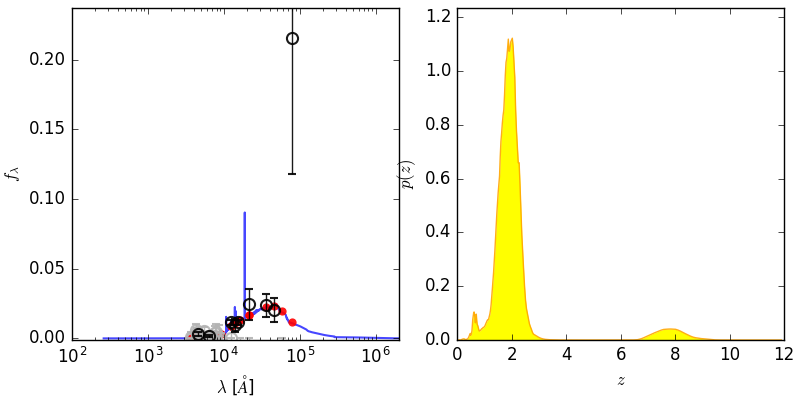

hh


In [37]:
from IPython.display import display, Image
im = Image('figure_11656.png')
display(im)

#plt.close(21)
#plt.figure(21)
#axes = eazy.plotExampleSED(idx=11656, writePNG=False, MAIN_OUTPUT_FILE='goodss_3dhst.v4.1',
                                     # OUTPUT_DIRECTORY='OUTPUT', CACHE_FILE='Same', lrange=[1e2, 2.e6],
                                     # axes=None, individual_templates=False, fnu=True)

#plt.show(21)


In [11]:
#2711.6059582824892, 7560.2142508609331, 7.3300000000000001
X = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 1]
Y = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 2]
ID = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 0]
for i in range(len(X)):
    if ((0 <= abs(X[i]- 2711) <= 10) & (0 <= abs(Y[i]-7560) <= 10)):
        print(ID[i])
        print('X',X[i])
        print('Y',Y[i])
print('end')

11625.0
('X', 2712.6060000000002)
('Y', 7561.2740000000003)
end


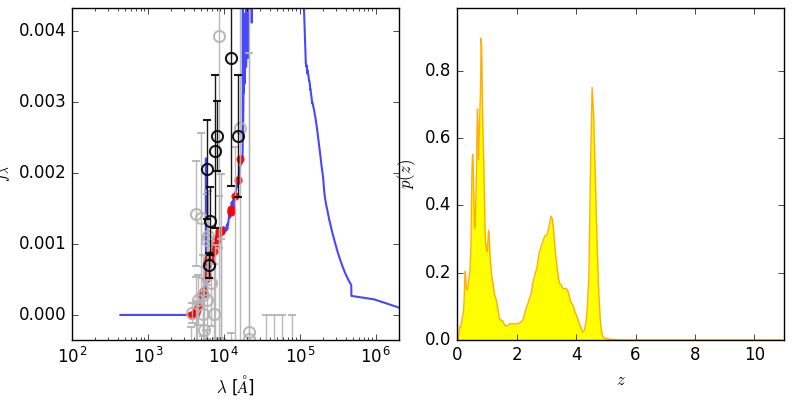

In [38]:
#axes = eazy.plotExampleSED(idx=11626, writePNG=False, MAIN_OUTPUT_FILE='goodss_3dhst.v4.1',
                                    #  OUTPUT_DIRECTORY='OUTPUT', CACHE_FILE='Same', lrange=[1e2, 2.e6],
                                    #  axes=None, individual_templates=False, fnu=True)

#plt.show()

im = Image('figure_11626.png')
display(im)


('ax, ay', 7236, 12408)
('Rad', 50)


<IPython.core.display.Javascript object>


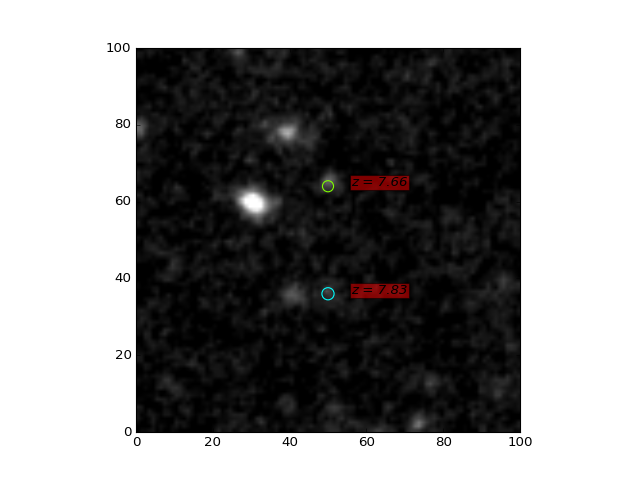

In [14]:
#(7286.8301586180951, 12472.544582702049, 7.8399999999999999)
#(7286.8431874130665, 12444.344572270777, 7.6600000000000001)
cut_fits(main_pic,'pair2.fits',50, 7286, 12458)

sot = pf.open('pair2.fits')
image_data = sot[0].data

plt.close(66)
plt.figure(66)
plt.imshow(image_data, cmap='gray', vmin=-0.3, vmax=5.5,extent=[0,100,0,100])
plt.text(56, 36,  'z = 7.83',style='italic', bbox={'facecolor':'red', 'alpha':0.5, 'pad':1})
plt.scatter(50, 36, s = 120, facecolors = 'none', edgecolors = 'cyan')

plt.scatter(50, 64, s = 100, facecolors = 'none', edgecolors = 'chartreuse')
plt.text(56, 64,  'z = 7.66',style='italic', bbox={'facecolor':'red', 'alpha':0.5, 'pad':1})
plt.xlim(0,100)
plt.ylim(0,100)
plt.show(66)


In [16]:
#(7286.8301586180951, 12472.544582702049, 7.8399999999999999)
X = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 1]
Y = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 2]
ID = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 0]
for i in range(len(X)):
    if ((0 <= abs(X[i]- 7286) <= 5) & (0 <= abs(Y[i]-12472) <= 5)):
        print(ID[i])
        print('X',X[i])
        print('Y',Y[i])
print('end')

29944.0
('X', 7286.5190000000002)
('Y', 12472.376)
end


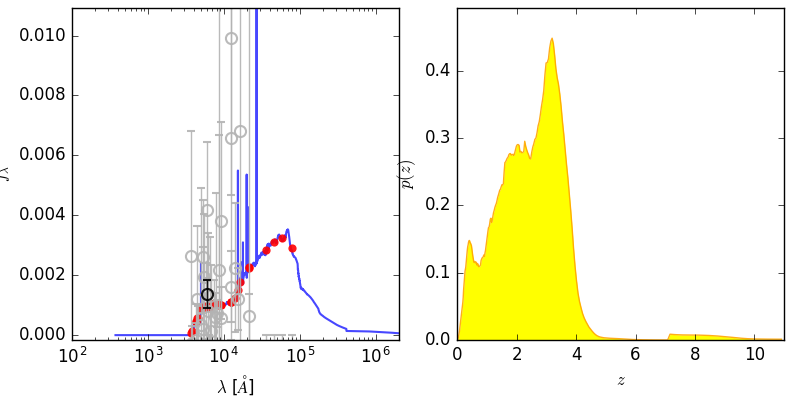

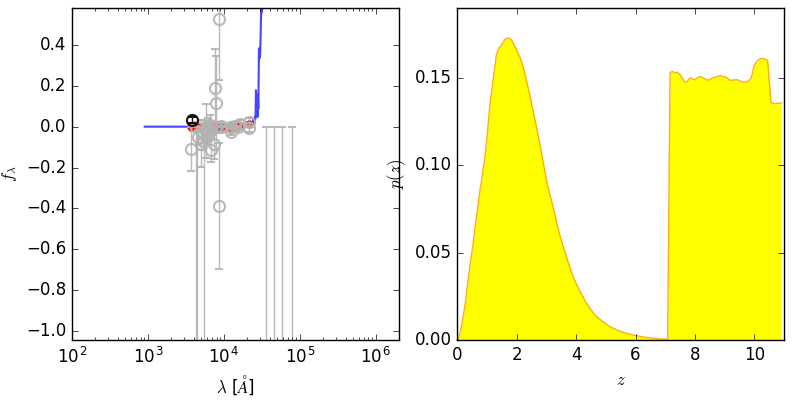

In [40]:
#axes = eazy.plotExampleSED(idx=29944, writePNG=False, MAIN_OUTPUT_FILE='goodss_3dhst.v4.1',
       #                             OUTPUT_DIRECTORY='OUTPUT', CACHE_FILE='Same', lrange=[1e2, 2.e6],
       #                             axes=None, individual_templates=False, fnu=True)
#plt.show()
im = Image('figure_29944.png')
display(im)
img = Image('figure_29943.png')
display(img)

In [17]:
#(7286.8431874130665, 12444.344572270777, 7.6600000000000001)
X = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 1]
Y = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 2]
ID = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 0]
for i in range(len(X)):
    if ((0 <= abs(X[i]- 7286) <= 5) & (0 <= abs(Y[i]-12444) <= 5)):
        print(ID[i])
        print('X',X[i])
        print('Y',Y[i])
print('end')

29814.0
('X', 7286.7879999999996)
('Y', 12443.698)
end


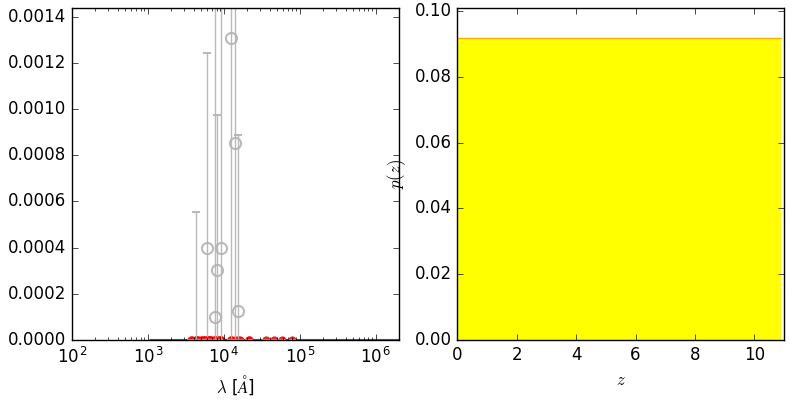

In [41]:
#axes = eazy.plotExampleSED(idx=29813, writePNG=False, MAIN_OUTPUT_FILE='goodss_3dhst.v4.1',
       #                               OUTPUT_DIRECTORY='OUTPUT', CACHE_FILE='Same', lrange=[1e2, 2.e6],
         #                             axes=None, individual_templates=False, fnu=True)
#plt.show()
im = Image('figure_29813.png')
display(im)

('ax, ay', 8648, 10737)
('Rad', 50)


<IPython.core.display.Javascript object>


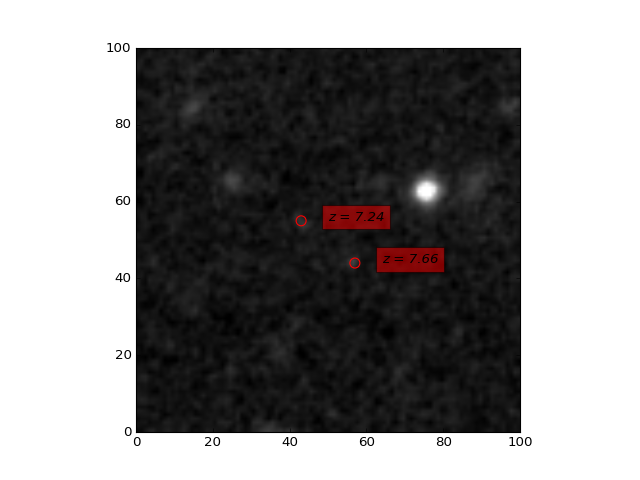

In [18]:
#8691.945859877058, 10782.841777357366, 7.2400000000000002)
#(8705.211831984223, 10793.045034224237, 7.6600000000000001)

cut_fits(main_pic,'pair3.fits',50, 8698, 10787)

sot = pf.open('pair3.fits')
image_data = sot[0].data
plt.close(5)
plt.figure(5)
plt.xlim(0,100)
plt.ylim(0,100)
plt.imshow(image_data, cmap='gray', vmin=-0.83, vmax=8.5,extent=[0,100,0,100],zorder=1)

plt.scatter(43, 55, s = 80, facecolors = 'none', edgecolors = 'r',zorder=2)
plt.text(50, 55,  'z = 7.24',style='italic', bbox={'facecolor':'red', 'alpha':0.5, 'pad':5})
plt.scatter(57, 44, s = 80, facecolors = 'none', edgecolors = 'r',zorder=2)
plt.text(64, 44,  'z = 7.66',style='italic', bbox={'facecolor':'red', 'alpha':0.5, 'pad':5})


plt.show(5)

In [19]:
#8691.945859877058, 10782.841777357366, 7.2400000000000002)
X = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 1]
Y = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 2]
ID = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 0]
for i in range(len(X)):
    if ((0 <= abs(X[i]- 8691) <= 10) & (0 <= abs(Y[i]-10782) <= 10)):
        print(ID[i])
        print('X',X[i])
        print('Y',Y[i])
print('end')

end


In [20]:
#(8705.211831984223, 10793.045034224237, 7.6600000000000001)
X = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 1]
Y = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 2]
ID = np.genfromtxt('goodss_3dhst.v4.1.cat')[:, 0]
for i in range(len(X)):
    if ((0 <= abs(X[i]- 8705) <= 15) & (0 <= abs(Y[i]-10793) <= 15)):
        print(ID[i])
        print('X',X[i])
        print('Y',Y[i])
print('end')

end


# Finding a Pair of Galaxies

('ax, ay', 9750, 6100)
('Rad', 2000)


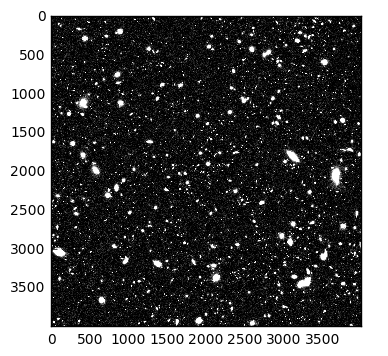

In [4]:
cut_fits(main_pic,'new.fits',2000,11750,8100)
plt.imshow(pf.open('new.fits')[0].data, vmax=1.902, vmin=-0.002, cmap='gray')
plt.show()
  

In [5]:
finding(9750, 6100, 2000)

('Galaxes', 5033)


In [7]:
find('goodss_3dhst.v4.1.zout','check.txt', np.genfromtxt('Table_gold.dat')[:, 0])

done


In [8]:
# Загружаем данные с красными смещениями
data = np.genfromtxt('check.txt', skip_header=1)

z_a  = data[:,2]
numb = data[:,0]

filt = (z_a > 7.000)

z_a1 = z_a[filt]
numb1 = numb[filt]
print(len(z_a1),len(numb1))

(31, 31)


In [9]:
# Загружаем координаты обьектов из главного каталога
XX = np.genfromtxt('Table_gold.dat')[:, 1]
YY = np.genfromtxt('Table_gold.dat')[:, 2]

# Отберём нужные
X1 = XX[filt]
Y1 = YY[filt]
print(len(X1))

31


In [10]:
Ax = np.zeros((len(X1),len(X1)))
Ay = np.zeros((len(Y1),len(Y1)))
Az = np.zeros((len(z_a1),len(z_a1)))

tx = np.zeros(len(X1))
ty = np.zeros(len(Y1))
tz = np.zeros(len(z_a1))
for j in range (len(X1)):   
     tx = abs(X1 - X1[j])
     Ax[j,:] = tx
     ty = abs(Y1 - Y1[j])
     Ay[j,:] = ty
     tz = abs(z_a1 - z_a1[j])
     Az[j,:] = tz


for i in range (len(Az)):
    for j in range (len(Az)):
        if i == j :
            Az[i,j] = 1
#print(Ax)
#print('-----------------------------------------------------------------------------------------------------------')
#print(Ay)
#print('-----------------------------------------------------------------------------------------------------------')
#print(Az)

In [11]:
candidatsx = [np.sum((Ax[i] > 0) & (Ax[i] < 35)) for i in range(len(X1))]
candidatsy = [np.sum((Ay[i] > 0) & (Ay[i] < 35)) for i in range(len(Y1))]
candidatsz = [np.sum((Az[i] >= 0) & (Az[i]  < 0.112)) for i in range(len(z_a1))]
print(candidatsx)
print(candidatsy)
print(candidatsz)

[0, 3, 3, 0, 1, 0, 0, 2, 2, 1, 0, 0, 1, 3, 1, 3, 0, 0, 0, 0, 0, 0, 1, 3, 0, 1, 0, 0, 0, 4, 1]
[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 4, 3, 3, 3, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 1, 1]
[1, 0, 1, 4, 2, 2, 2, 2, 0, 4, 5, 4, 3, 1, 4, 1, 5, 5, 2, 5, 2, 2, 5, 6, 1, 3, 5, 3, 2, 2, 2]


In [51]:
# Из столбцов координат и красного смещения выбираем обьекты, где выполняются все три критерия
X1 = np.array(X1)
x = X1[np.where((np.array(candidatsx)>0) & (np.array(candidatsy)>0)  & (np.array(candidatsz)>0) )[0]]

Y1 = np.array(Y1)
y = Y1[np.where( (np.array(candidatsx)>0)  & (np.array(candidatsy)>0)  & (np.array(candidatsz)>0) )[0]]

z_a1 = np.array(z_a1)
z = z_a1[np.where((np.array(candidatsx)>0) & (np.array(candidatsy)>0)  & (np.array(candidatsz)>0) )[0]]

n = np.array(numb1)
m = n[np.where((np.array(candidatsx)>0) & (np.array(candidatsy)>0)  & (np.array(candidatsz)>0) )[0]]

print(len(x),len(y),len(z),len(m))
print(x)
print(y)
print(z)

31
(8, 8, 8, 8)
[ 3850.185  2461.971  1431.006  1478.677  2486.187  3831.178  1463.535
  2425.479]
[  846.824  1899.235  1928.663  1934.837  3372.085  3399.375  3903.618
  3914.684]
[ 7.927  8.197  9.678  7.579  9.572  7.494  7.081  7.081]


In [52]:
Yes = np.vstack((m, x, y, z))
np.savetxt('int.dat', np.transpose(Yes), delimiter="  ", fmt="%s")

In [54]:
dats = np.genfromtxt('int.dat')
r = []
f=[]
v=[]
num = []
for i in range(len(dats)+1):
    for j in range(i+1, len(dats)):
        if (0<abs(dats[i,1] - dats[j,1]) <48)&(0< abs(dats[i,2] - dats[j,2]) <30)&(0< abs(dats[i,3] - dats[j,3]) <3):
            r.append(dats[i,1])
            r.append(dats[j,1])
            f.append(dats[i,2])
            f.append(dats[j,2])
            v.append(dats[i,3])
            v.append(dats[j,3])
            num.append(dats[i,0])
            num.append(dats[j,0])
            print('y')
print(r) 
print(f)
print(v)
Yes = np.vstack((num, r, f, v))
np.savetxt('get.dat', np.transpose(Yes), delimiter="  ", fmt="%s")

y
[1431.0060000000001, 1478.6769999999999]
[1928.663, 1934.837]
[9.6780000000000008, 7.5789999999999997]


In [57]:
data = np.genfromtxt('goodss_3dhst.v4.1.zout', skip_header=1)

z_a  = data[:,2]
k = 0
for i in range(len(z_a)):
    if(z_a[i]>7):
        k+=1
print(k)


print(num[0],num[1])

1249
(13525.0, 13546.0)


# Plotting

In [33]:
numbr = 0
X_o = np.genfromtxt('get.dat')[numbr, 0]
Y_o = np.genfromtxt('get.dat')[numbr, 1]
print(X_o,Y_o)
cut_fits('new.fits','one_obj.fits',10,X_o,Y_o)

numbr = 1
X_o = np.genfromtxt('get.dat')[numbr, 0]
Y_o = np.genfromtxt('get.dat')[numbr, 1]
print(X_o,Y_o)
cut_fits('new.fits','two_obj.fits',10,X_o,Y_o)


(1431.0060000000001, 1928.663)
('ax, ay', 1421, 1918.663)
('Rad', 10)
(1478.6769999999999, 1934.837)
('ax, ay', 1468, 1924.837)
('Rad', 10)


Image1
('Min:', -0.74317008)
('Max:', 2.4337502)
('Mean:', 0.23385036)
('Stdev:', 0.46712327)
()
-----------------------------------------------------------------------------------------------------------
()
Image2
('Min:', -0.78556174)
('Max:', 2.0178456)
('Mean:', 0.10768442)
('Stdev:', 0.3724758)


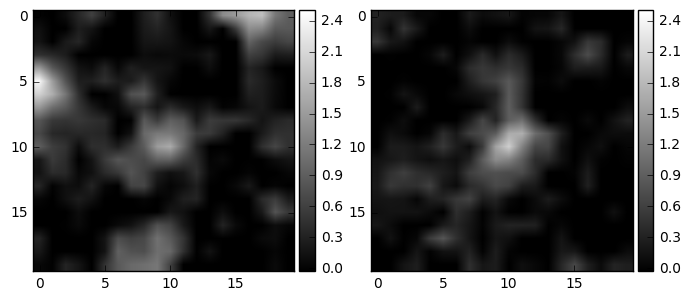

In [64]:
sot1 = pf.open('one_obj.fits')
image1_data = sot1[0].data

print('Image1')
print('Min:', np.min(image1_data))
print('Max:', np.max(image1_data))
print('Mean:', np.mean(image1_data))
print('Stdev:', np.std(image1_data))

sot2 = pf.open('two_obj.fits')
image2_data = sot2[0].data


print()
print('-----------------------------------------------------------------------------------------------------------')
print()


print('Image2')
print('Min:', np.min(image2_data))
print('Max:', np.max(image2_data))
print('Mean:', np.mean(image2_data))
print('Stdev:', np.std(image2_data))

plt.figure(1, figsize=(8,6))

plt.subplot(121)
ax = plt.gca()
im1 = ax.imshow(image1_data, cmap='gray', vmin=-0.03, vmax=2.5)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="6%", pad=0.05)
plt.colorbar(im1, cax=cax1)




plt.subplot(122)
ax = plt.gca()
im2 = ax.imshow(image2_data, cmap='gray', vmin=-0.03, vmax=2.5)
divider = make_axes_locatable(ax)
cax2 = divider.append_axes("right", size="6%", pad=0.05)
plt.colorbar(im2, cax=cax2)


plt.show(1)
plt.close(1)



In [66]:
#plt.figure(2, figsize=(8,8))
#plt.subplot(211)
#axes = eazy.plotExampleSED(idx=num[0], writePNG=False, MAIN_OUTPUT_FILE='goodss_3dhst.v4.1',
                                     # OUTPUT_DIRECTORY='OUTPUT', CACHE_FILE='Same', lrange=[1e2, 2.e6],
                                     # axes=None, individual_templates=False, fnu=True)

#plt.subplot(212)
#axes = eazy.plotExampleSED(idx=num[1], writePNG=False, MAIN_OUTPUT_FILE='goodss_3dhst.v4.1',
                                    #  OUTPUT_DIRECTORY='OUTPUT', CACHE_FILE='Same', lrange=[1e2, 2.e6],
                                    #  axes=None, individual_templates=False, fnu=True)
#plt.show(2)
#plt.close(2)

In [10]:
 
axes = eazy.plotExampleSED(idx=6, writePNG=False, MAIN_OUTPUT_FILE='goodss_3dhst.v4.1',
                                  OUTPUT_DIRECTORY='OUTPUT', CACHE_FILE='Same', lrange=[1e2, 2.e6],
                                  axes=None, individual_templates=False, fnu=True)
plt.show()
plt.close()

AttributeError: 'function' object has no attribute 'plotExampleSED'

# Finding objects by Photutils

In [4]:
# input a 2D circular Gaussian kernel with a FWHM of 2 pixels
# i haven`t used it yet
sigma = 2.0 * gaussian_fwhm_to_sigma 
kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)

kernel.normalize()


In [5]:
# generate a simple threshold at 3.63 sigma above the background
# min size of source - 4 pixel

npixels = 4
threshold = detect_threshold(data, snr=3.57)

# find sources

segm = detect_sources(data, threshold, npixels)
print('Found {0} sources'.format(segm.nlabels))

Found 253 sources


In [8]:
# find sources again 
segm2 = deblend_sources(data, segm, npixels,
                        contrast=0.001, nlevels=32)
print('Found {0} sources'.format(segm2.max))

Found 255 sources


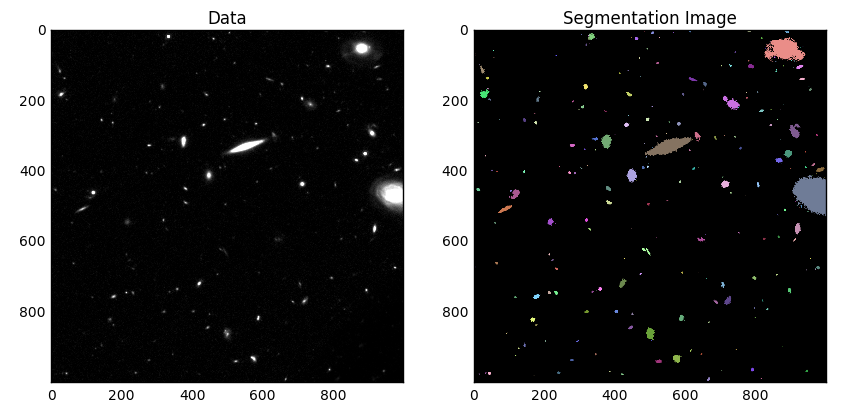

In [11]:
# plot all
rand_cmap = random_cmap(random_state=12345)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.imshow(data, cmap='gray', vmin=1.e-4, vmax=1.e-1)
ax1.set_title('Data')
ax2.imshow(segm2, cmap=rand_cmap)
ax2.set_title('Segmentation Image')
plt.show()

In [16]:

eff_gain = hdu.header['TEXPTIME']
print(eff_gain)
erro = calc_total_error(data, error, eff_gain)
print(erro)

398226.0986700011
[[  36247.03861007   37556.95749126   33464.17881855 ...,   40323.09035776
    41477.17251694   40849.7030589 ]
 [  35039.88310483   34767.4993061    34492.75309395 ...,   40170.46556862
    38208.51925945   39769.12893187]
 [  36297.51903368   35280.78185075   34996.84465777 ...,   39234.63612677
    41411.0462558    39718.59413423]
 ..., 
 [  34136.8858568    35305.84812747   33615.35077907 ...,  468185.59492577
   476803.36750489  410636.2092948 ]
 [  31523.50234349   32779.76937076   33852.65578947 ...,  483908.53271254
   433940.89861178  407724.28519282]
 [  35765.91807853   36622.53907091   36127.90965445 ...,  403925.61501346
   405232.61625886  452245.50189471]]


In [17]:
# photometry and morphological properties of detected sources
# i have problem with error

wcs = WCS(hdu)
props = source_properties(data, segm2, wcs=wcs,error = error)
tbl = properties_table(props)
columns = ['id', 'xcentroid', 'ycentroid', 'source_sum','source_sum_err','area']
tbl2 = properties_table(props, columns=columns)
print(tbl2)

 id   xcentroid     ycentroid   source_sum source_sum_err  area
         pix           pix                                 pix2
--- ------------- ------------- ---------- -------------- -----
  1  432.12653613 1.31770237323   0.915105  209508.942053  42.0
  2 579.207149234  1.0293438071   0.927776  182598.742077  32.0
  3 780.394802545 3.86434472935    1.14133  306415.995196  63.0
  4 885.284635013 3.58764662092    3.26402   424424.35097 120.0
  5 612.163331273 5.94180175419   0.405045  177377.286663  31.0
  6 481.591819232 6.17189479974  0.0602942  72784.2013627   5.0
  7 505.154646664 9.84186824838    1.17705   221734.63881  48.0
  8 564.486268609 9.24895438227  0.0926706  93412.0304029   8.0
  9 304.004475974 14.7625292857   0.044292  65828.6605059   4.0
 10  460.16682499 26.9282803364    2.35201  277847.267397  74.0
...           ...           ...        ...            ...   ...
246  239.63254755 973.364730328    1.27864   263478.84876  55.0
247 32.4127123673 974.668813508   0.2414